# Preparing Dataset

Loading and defining data preparation pipeline

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import tensorflow_datasets as tfds

(train_ds, test_ds), ds_info = tfds.load("mnist" , split =["train", "test"] , as_supervised=True , with_info=True)

# print(ds_info)

print("How many training/test images are there?")
print(ds_info.splits['train'].num_examples)
print(ds_info.splits['test'].num_examples)

print("What iss the image shape?")
print(ds_info.features['image'].shape)

print("What range are pixel values in?")
print(ds_info.features['image'].dtype)
print(tf.uint8.min)
print(tf.uint8.max)

def prepare(ds: tf.data.Dataset):
  def reshape(image, label):
      return tf.reshape(image, [-1]), label
  ds = ds.map(reshape)
  
  def normalize(image, label):
      return (tf.cast(image, tf.float32) / 128) - 1., label
  ds = ds.map(normalize)

  def one_hot(image, label):
      return image, tf.one_hot(label, 10)
  ds = ds.map(one_hot)

  ds = ds.cache()
  ds = ds.shuffle(1000)
  ds = ds.batch(32)
  ds = ds.prefetch(20)

  return ds

train_ds = train_ds.apply(prepare)
test_ds = test_ds.apply(prepare)

How many training/test images are there?
60000
10000
What iss the image shape?
(28, 28, 1)
What range are pixel values in?
<dtype: 'uint8'>
0
255


# Classes

In [3]:
import tensorflow as tf

class MLP(tf.Module):
  """
  MLP model holding layers.
  """

  def __init__(self):
    """
    Define the layers.
    Input size is not given since we feed the input in call step.
    """
    super(MLP, self).__init__()

    self.first_hidden = tf.keras.layers.Dense(256, activation=tf.nn.relu)
    self.second_hidden = tf.keras.layers.Dense(256, activation=tf.nn.relu)

    # activate = softmax: in our one-hot vector we dont want an activated or not,
    # we get an output [-1, 1] which sums up to 1
    # this fits well with our desire to choose the best fitting number
    self.output_layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

  @tf.function
  def __call__(self, inputs):
    """
    Propagates inputs through network.
    """
    x = self.first_hidden(inputs)
    x = self.second_hidden(x)
    x = self.output_layer(x)
    return x


In [4]:
import numpy as np

def training_step(model, input, target, loss_function, optimizer):
  """
  Performs 1 step in which we feed an input to the network,
  get a prediction, compute a loss and with the tf.GradientTape()
  we can compute gradients and implement backpropagation with the optimizer.
  returns loss to keep track
  """
  with tf.GradientTape() as tape:
      prediction = model(input)
      loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss

def test(model, test_data, loss_function):
  """
  Takes current state of our model and computes loss/accuracies.
  """
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
      prediction = model(input)
      sample_test_loss = loss_function(target, prediction)

      # how often prediction and target are the same
      sample_test_accuracy = tf.argmax(target, axis=1) == tf.argmax(prediction, axis=1)
      sample_test_accuracy = np.mean(sample_test_accuracy)

      # track metrics
      test_loss_aggregator.append(tf.reduce_mean(sample_test_loss.numpy()))
      test_accuracy_aggregator.append(sample_test_accuracy)

  # overall metrics
  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [5]:
epochs = 10
learning_rate = 0.1

model = MLP()

# to compute losses for one-hot vectors
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.SGD(learning_rate)

# metrics
train_losses = []
test_losses = []
test_accuracies = []

# test_data before training
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# training_data before training
train_loss, _ = test(model, train_ds, cross_entropy_loss)
test_losses.append(train_loss)

# training loop
for epoch in range(epochs):
    print(f'Epoch: {epoch} starts with accuracy: {test_accuracies[-1]}')
    epoch_loss_agg = []

    for input, target in train_ds:
        train_loss = training_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    # metrics
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

# metrics after training
train_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
print(f"after Training, loss: {train_loss}, accuracy: {test_accuracy}")

Epoch: 0 starts with accuracy: 0.10922523961661341
Epoch: 1 starts with accuracy: 0.9560702875399361
Epoch: 2 starts with accuracy: 0.9609624600638977
Epoch: 3 starts with accuracy: 0.9638578274760383
Epoch: 4 starts with accuracy: 0.9714456869009584
Epoch: 5 starts with accuracy: 0.9768370607028753
Epoch: 6 starts with accuracy: 0.9766373801916933
Epoch: 7 starts with accuracy: 0.9776357827476039
Epoch: 8 starts with accuracy: 0.977935303514377
Epoch: 9 starts with accuracy: 0.9766373801916933
after Training, loss: 0.07430752366781235, accuracy: 0.9787340255591054


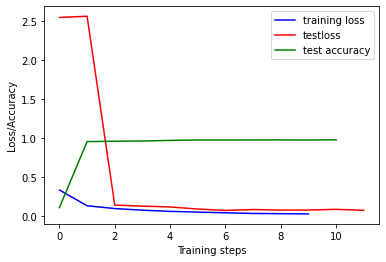

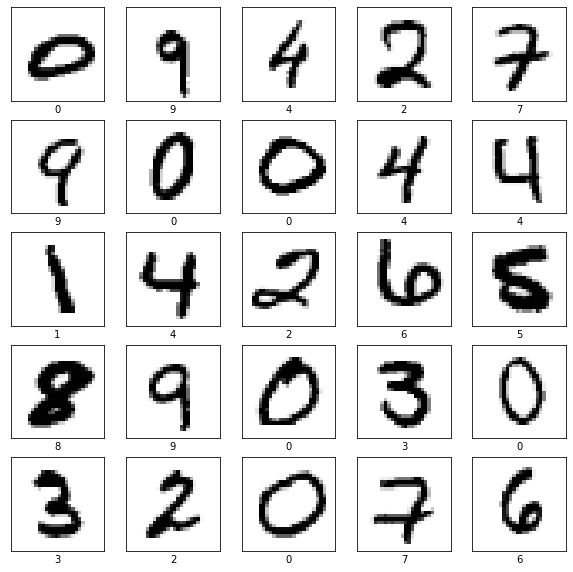

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualize the test_losses, test_accuracies and train_losses over time
# in the .pdf we are told to visualize train_accuracy aswell but that did not make sense to us
def visualization(test_losses, test_accuracies, train_losses):
    plt.figure()
    line1, = plt.plot(train_losses, "b")
    line2, = plt.plot(test_losses, "r" )
    line3, = plt.plot(test_accuracies, "g" )
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line3),("training loss", "testloss" , "test accuracy"))
    plt.show()

    for image, label in test_ds.take(1):
      image = image.numpy()
      label = label.numpy()

      predictions = model(image)

      plt.figure(figsize=(10, 10))
      for i in range(25):
          plt.subplot(5, 5, i+1)
          plt.xticks([])
          plt.yticks([])
          plt.grid(False)
          plt.imshow(image[i].reshape(28, 28), cmap=plt.cm.binary)
          plt.xlabel(np.argmax(predictions[i]))
    plt.show()


visualization(test_losses, test_accuracies, train_losses)